# Лабораторная работа 3

Необходимо разработать программу, обеспечивающую кластеризацию новостного потока. Необходимо загрузить новостную ленту, указанную преподавателем, выделив из нее тематические пометы (при наличии). Далее следует векторизовать тексты, провести их кластеризацию и проверить точность кластеризации по тематическим пометам. Также следует выбрать один из кластеров и обучить на нем классификатор. Точность работы классификатора определяется при помощи f1-меры и матрицы ошибок.

Требования к заданию:
- выгрузить всю новостную ленту - 1 балла;
- векторизовать тексты новостей - 1 балла;
- кластеризовать векторы новостей - 2 балла;
- выбрать число кластеров одним из методов оценки (локтя, Дэвиса-Болдуина, …), оценить качество кластеризации по RAND Index - 1 балла;
- выбрать кластер новостей, обучить классификатор - 2 балла;
- проверить точность работы классификатора - 1 балл.
- cубъективное мнение преподавателя - 2 балла.


In [132]:
import csv
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
import pymorphy2
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

In [133]:
# "date","type","name","title","text" - headers for CSV
with open('./src/cbr-news.csv', 'r', encoding='UTF-8') as NEWS:
    txt_news = csv.reader(NEWS, delimiter=',')
    news = pd.DataFrame(txt_news, columns=["date","type","name","title","text"])

# transforming data to provide accuracy form
news.drop('type', axis=1, inplace=True)
news['content'] = news[['title', 'text']].agg(' '.join, axis=1)
news.drop(columns=['title', 'text'], axis=1, inplace=True)
no_data_news = news.drop('date', axis=1)
no_data_news.head()

,name,content
0,Финансовый конгресс Банка России пройдет 6–7 июля,"Банк России возобновляет проведение традиционного Финансового конгресса. В этом году он состоится 6–7 июля в Санкт-Петербурге. Тема пленарной сессии — структурная перестройка экономики и финансовых рынков. В программу также включены вопросы регулирования в финансовом секторе, развития экономики в новых условиях, денежно-кредитной политики и многие другие. В мероприятии примут участие руководители крупнейших игроков российского финансового рынка, представители Банка России, регуляторов стран — партнеров России. «В этом году мы возвращаемся к проведению Финансового конгресса Банка России, чтобы вместе с участниками рынка осмыслить произошедшие перемены и обсудить развитие в новых условиях. Очень многое кардинально изменилось, и важно сохранить какие-то опоры, привычки и традиции, и одна из них — наш конгресс», — отметила Председатель Банка России Эльвира Набиуллина. Предварительная программа и регистрация доступны на официальном сайте конгресса."
1,Военнослужащие и члены их семей получили более 188 тысяч кредитных каникул,"С конца сентября 2022 года до 31 марта 2023 года банки предоставили участникам СВО и членам их семей каникулы по 188,3 тыс. кредитов на сумму 72,4 млрд рублей, в том числе в марте — по 8,4 тыс. кредитов на сумму 3,1 млрд рублей. Без учета кредитных каникул, оформленных в связи с СВО, банки за март реструктурировали 59,2 тыс. кредитов граждан на 30,4 млрд рублей и 1,7 тыс. кредитов субъектов малого и среднего предпринимательства на 19,7 млрд рублей. Подробнее читайте в бюллетене «Динамика реструктуризации кредитов населения и бизнеса». В дальнейшем бюллетень будет выходить ежеквартально, в следующем выпуске регулятор представит данные по состоянию на конец июня."
2,В 2022 году МФО увеличили кредитование бизнеса на 40%,"В прошлом году микрофинансовые организации (МФО) предпринимательского финансирования выдали малому и среднему бизнесу займов на 70 млрд рублей. При этом 80% общего объема займов пришлось на государственные МФО, но крупные коммерческие МФО также нарастили кредитование. 13% займов было выдано дистанционно. Таким каналом получения денег активно пользуются предприниматели, ведущие деятельность на маркетплейсах. Предприятия оптово-розничной торговли лидируют среди заемщиков по объему и количеству займов. Подробнее читайте в материале «Тенденции на рынке МФО предпринимательского финансирования в 2022 году». Фото на превью: Prostock-studio / Shutterstock / Fotodom"
3,"Пенсионные накопления застрахованы государством на 2,8 млн рублей","Предельный размер гарантийного возмещения по добровольным пенсионным накоплениям увеличен с 1,4 до 2,8 млн рублей. Страховка действует в случаях банкротства негосударственного пенсионного фонда (НПФ) или аннулирования его лицензии. Такой закон одобрил Совет Федерации, и он вступит в силу со дня официального опубликования. Это будет способствовать повышению доверия к пенсионной системе и привлечению новых клиентов в НПФ. Система гарантирования негосударственного пенсионного обеспечения заработала с 1 января 2023 года. Фото на превью: Артем Геодакян / ТАСС"
4,Фальшивок стало меньше: итоги I квартала,"В I квартале 2023 года в банковской системе России поддельных рублей обнаружено почти на 63% меньше, чем за такой же период 2022 года. Количество фальшивых банкнот иностранных государств сократилось почти на 46%. С подробной информацией можно ознакомиться в материале Банка России. Фото на превью: Артем Геодакян / ТАСС"


In [134]:
morph = pymorphy2.MorphAnalyzer()
imp_POS = ['ADJF', 'ADJS', 'NOUN', 'VERB', 'PRTF', 'PRTS', 'GRND']

def normalize_pm2(txt):
    words = []
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', txt)
    for t in tokens:
        pv = morph.parse(t)
        words.append(pv[0].normal_form)
    return words


def get_most_freq_words_filter(txt):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', txt)
    words = []

    for t in tokens:
        pv = morph.parse(t)
        if pv[0].tag.POS in imp_POS and pv[0].normal_form != 'быть':
            words.append(pv[0].normal_form)
    txt = ' '.join(words)

    counter = CountVectorizer(ngram_range=(1,2), token_pattern=r'[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+')

    res = counter.fit_transform([txt])
    frq = sorted([(i, int(res[0][0,i])) for i in range(res[0].shape[1])], key = lambda x: x[1], reverse = True)[:5]
    vocab = {w:res[0,i] for w, i in counter.vocabulary_.items()}

    return [[w for w, n in counter.vocabulary_.items() if n==i][0] for i, f in frq], vocab

vocabs = []
for i in tqdm(range(news.shape[0])):
    fw, v = get_most_freq_words_filter(news.content.iloc[i])
    vocabs.append(v)

news['Vocabular'] = vocabs

tfCounter = TfidfVectorizer(ngram_range=(1,2), token_pattern=r'[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+')
tfres = tfCounter.fit_transform([' '.join(normalize_pm2(n)) for n in news.content] )

freq_words = []
for i in tqdm(range(news.shape[0])):

    tfs = [(k,tfres[i][0, tfCounter.vocabulary_.get(k)]) for k in news.Vocabular.iloc[i]
         if k in tfCounter.vocabulary_.keys()]
    fw = [w for w, f in sorted(tfs, key = lambda x: x[1], reverse = True)[:5]]
    freq_words.append(fw)

news['Freq Words TFIDF'] = freq_words

news.head()


100%|██████████| 999/999 [00:05<00:00, 177.68it/s]


,date,name,content,Vocabular,Freq Words TFIDF
0,"﻿""27 апреля 2023""",Финансовый конгресс Банка России пройдет 6–7 июля,"Банк России возобновляет проведение традиционного Финансового конгресса. В этом году он состоится 6–7 июля в Санкт-Петербурге. Тема пленарной сессии — структурная перестройка экономики и финансовых рынков. В программу также включены вопросы регулирования в финансовом секторе, развития экономики в новых условиях, денежно-кредитной политики и многие другие. В мероприятии примут участие руководители крупнейших игроков российского финансового рынка, представители Банка России, регуляторов стран — партнеров России. «В этом году мы возвращаемся к проведению Финансового конгресса Банка России, чтобы вместе с участниками рынка осмыслить произошедшие перемены и обсудить развитие в новых условиях. Очень многое кардинально изменилось, и важно сохранить какие-то опоры, привычки и традиции, и одна из них — наш конгресс», — отметила Председатель Банка России Эльвира Набиуллина. Предварительная программа и регистрация доступны на официальном сайте конгресса.","{'банк': 4, 'россия': 5, 'возобновлять': 1, 'проведение': 2, 'традиционный': 1, 'финансовый': 5, 'конгресс': 4, 'год': 2, 'состояться': 1, 'июль': 1, 'санкт-петербург': 1, 'тема': 1, 'пленарный': 1, 'сессия': 1, 'структурный': 1, 'перестройка': 1, 'экономика': 2, 'рынок': 3, 'программа': 2, 'включить': 1, 'вопрос': 1, 'регулирование': 1, 'сектор': 1, 'развитие': 2, 'новый': 2, 'условие': 2, 'денежно-кредитный': 1, 'политика': 1, 'другой': 1, 'мероприятие': 1, 'принять': 1, 'участие': 1, 'руководитель': 1, 'крупный': 1, 'игрок': 1, 'российский': 1, 'представитель': 1, 'регулятор': 1, 'страна': 1, 'партнёр': 1, 'возвращаться': 1, 'участник': 1, 'произойти': 1, 'перемена': 1, 'измениться': 1, 'какой-то': 1, 'опора': 1, 'привычка': 1, 'традиция': 1, 'один': 1, 'наш': 1, 'отметить': 1, 'председатель': 1, 'эльвира': 1, 'набиуллин': 1, 'предварительный': 1, 'регистрация': 1, 'доступный': 1, 'официальный': 1, 'сайт': 1, 'банк россия': 4, 'россия возобновлять': 1, 'возобновлять проведение': 1, 'проведение традиционный': 1, 'традиционный финансовый': 1, 'финансовый конгресс': 2, 'конгресс год': 1, 'год состояться': 1, 'состояться июль': 1, 'июль санкт-петербург': 1, 'санкт-петербург тема': 1, 'тема пленарный': 1, 'пленарный сессия': 1, 'сессия структурный': 1, 'структурный перестройка': 1, 'перестройка экономика': 1, 'экономика финансовый': 1, 'финансовый рынок': 2, 'рынок программа': 1, 'программа включить': 1, 'включить вопрос': 1, 'вопрос регулирование': 1, 'регулирование финансовый': 1, 'финансовый сектор': 1, 'сектор развитие': 1, 'развитие экономика': 1, 'экономика новый': 1, 'новый условие': 2, 'условие денежно-кредитный': 1, 'денежно-кредитный политика': 1, 'политика другой': 1, 'другой мероприятие': 1, 'мероприятие принять': 1, 'принять участие': 1, 'участие руководитель': 1, 'руководитель крупный': 1, 'крупный игрок': 1, 'игрок российский': 1, 'российский финансовый': 1, 'рынок представитель': 1, ...}","[конгресс, финансовый конгресс, новый условие, финансовый, проведение]"
1,27 апреля 2023,Военнослужащие и члены их семей получили более 188 тысяч кредитных каникул,"С конца сентября 2022 года до 31 марта 2023 года банки предоставили участникам СВО и членам их семей каникулы по 188,3 тыс. кредитов на сумму 72,4 млрд рублей, в том числе в марте — по 8,4 тыс. кредитов на сумму 3,1 млрд рублей. Без учета кредитных каникул, оформленных в связи с СВО, банки за март реструктурировали 59,2 тыс. кредитов граждан на 30,4 млрд рублей и 1,7 тыс. кредитов субъектов малого и среднего предпринимательства на 19,7 млрд рублей. Подробнее читайте в бюллетене «Динамика реструктуризации кредитов населения и бизнеса». В дальнейшем бюллетень будет выходить ежеквартально, в следующем выпуске регулятор представит данные по состоянию на конец июня.","{'конец': 2, 'сентябрь': 1, 'год': 2, 'март': 3, 'банк': 2, 'предоставить': 1, 'участник': 1, 'член': 1, 'семья': 1, 'каникулы': 2, 'тыс': 4, 'кр

In [135]:
news_murder = news[news.content.str.contains("рыно")]
news_murder.head()

,date,name,content,Vocabular,Freq Words TFIDF
7,20 апреля 2023,В марте заметно ускорился рост во всех сегментах розничного кредитования,"Ипотечный портфель вырос на 2,1% (в феврале — на 1,5%), что в целом соответствует докризисному уровню. Увеличились выдачи как рыночной (+30%), так и льготной ипотеки (+40%). Потребительское кредитование также ускорилось — до 1,4% с 0,5% в феврале. В корпоративном кредитовании сохраняется уверенный рост (+1,5%), как месяцем ранее. Объем средств населения в банках умеренно увеличился (+0,7%), а средства компаний сократились на 1,6% из-за крупных налоговых выплат. В марте банки заработали 330 млрд рублей прибыли. Это превысило результат февраля (293 млрд рублей) благодаря росту чистых процентных и комиссионных доходов, а также действию ряда разовых факторов, в том числе положительной переоценке ценных бумаг. Более подробно читайте в информационно-аналитическом материале «О развитии банковского сектора Российской Федерации в марте 2023 года». Фото на превью: Dark_Side / Shutterstock / Fotodom","{'ипотечный': 1, 'портфель': 1, 'вырасти': 1, 'февраль': 3, 'целое': 1, 'соответствовать': 1, 'докризисный': 1, 'уровень': 1, 'увеличиться': 2, 'выдача': 1, 'рыночный': 1, 'льготный': 1, 'ипотека': 1, 'потребительский': 1, 'кредитование': 2, 'ускориться': 1, 'корпоративный': 1, 'сохраняться': 1, 'уверенный': 1, 'рост': 2, 'месяц': 1, 'объём': 1, 'средство': 2, 'население': 1, 'банк': 2, 'компания': 1, 'сократиться': 1, 'крупный': 1, 'налоговый': 1, 'выплата': 1, 'март': 2, 'заработать': 1, 'млрд': 2, 'рубль': 2, 'прибыль': 1, 'превысить': 1, 'результат': 1, 'чистый': 1, 'процентный': 1, 'комиссионный': 1, 'доход': 1, 'действие': 1, 'ряд': 1, 'разовый': 1, 'фактор': 1, 'тот': 1, 'число': 1, 'положительный': 1, 'переоценка': 1, 'ценный': 1, 'бумага': 1, 'читать': 1, 'информационно-аналитический': 1, 'материал': 1, 'развитие': 1, 'банковский': 1, 'сектор': 1, 'российский': 1, 'федерация': 1, 'год': 1, 'фото': 1, 'превью': 1, 'ипотечный портфель': 1, 'портфель вырасти': 1, 'вырасти февраль': 1, 'февраль целое': 1, 'целое соответствовать': 1, 'соответствовать докризисный': 1, 'докризисный уровень': 1, 'уровень увеличиться': 1, 'увеличиться выдача': 1, 'выдача рыночный': 1, 'рыночный льготный': 1, 'льготный ипотека': 1, 'ипотека потребительский': 1, 'потребительский кредитование': 1, 'кредитование ускориться': 1, 'ускориться февраль': 1, 'февраль корпоративный': 1, 'корпоративный кредитование': 1, 'кредитование сохраняться': 1, 'сохраняться уверенный': 1, 'уверенный рост': 1, 'рост месяц': 1, 'месяц объём': 1, 'объём средство': 1, 'средство население': 1, 'население банк': 1, 'банк увеличиться': 1, 'увеличиться средство': 1, 'средство компания': 1, 'компания сократиться': 1, 'сократиться крупный': 1, 'крупный налоговый': 1, 'налоговый выплата': 1, 'выплата март': 1, 'март банк': 1, 'банк заработать': 1, 'заработать млрд': 1, 'млрд рубль': 2, ...}","[февраль, соответствовать докризисный, уровень увеличиться, увеличиться выдача, ипотека потребительский]"
18,11 апреля 2023,Банк России ограничит рискованные ипотечные программы с экстремально низкими ставками,"Банк России дестимулирует выдачу ипотечных кредитов, полная стоимость (ПСК) которых существенно ниже рыночного уровня. С 30 мая 2023 года по таким ссудам, выданным после 15 марта 2023 года, банкам необходимо будет формировать дополнительные резервы. При этом у них остается достаточно возможностей для рыночного снижения ставок. Соответствующие изменения внесены в Положение Банка России № 590-П. В последнее время распространение получила так называемая «ипотека от застройщика» с экстремально низкими нерыночными ставками вплоть до 0,1%, которые достигаются за счет завышения цены приобретаемой квартиры на 20–30%. Эту разницу застройщик затем в виде комиссии платит банку для компенсации его выпадающих доходов. Такие программы несут риски для заемщиков, банков, а также искажают общую статистику, что в итоге мешает принятию взвешенных решений всеми участниками. Регули

In [136]:
news_mortgage = news[news.content.str.contains("заем")]
news_mortgage.head()

,date,name,content,Vocabular,Freq Words TFIDF
2,27 апреля 2023,В 2022 году МФО увеличили кредитование бизнеса на 40%,"В прошлом году микрофинансовые организации (МФО) предпринимательского финансирования выдали малому и среднему бизнесу займов на 70 млрд рублей. При этом 80% общего объема займов пришлось на государственные МФО, но крупные коммерческие МФО также нарастили кредитование. 13% займов было выдано дистанционно. Таким каналом получения денег активно пользуются предприниматели, ведущие деятельность на маркетплейсах. Предприятия оптово-розничной торговли лидируют среди заемщиков по объему и количеству займов. Подробнее читайте в материале «Тенденции на рынке МФО предпринимательского финансирования в 2022 году». Фото на превью: Prostock-studio / Shutterstock / Fotodom","{'прошлый': 1, 'год': 2, 'микрофинансовый': 1, 'организация': 1, 'предпринимательский': 2, 'финансирование': 2, 'выдать': 2, 'малый': 1, 'средний': 1, 'бизнес': 1, 'заём': 4, 'млрд': 1, 'рубль': 1, 'общий': 1, 'объём': 2, 'прийтись': 1, 'государственный': 1, 'крупный': 1, 'коммерческий': 1, 'нарастить': 1, 'кредитование': 1, 'такой': 1, 'канал': 1, 'получение': 1, 'деньга': 1, 'пользоваться': 1, 'предприниматель': 1, 'ведущий': 1, 'деятельность': 1, 'маркетплейс': 1, 'предприятие': 1, 'оптово-розничный': 1, 'торговля': 1, 'лидировать': 1, 'заёмщик': 1, 'количество': 1, 'читать': 1, 'материал': 1, 'тенденция': 1, 'рынок': 1, 'фото': 1, 'превью': 1, 'прошлый год': 1, 'год микрофинансовый': 1, 'микрофинансовый организация': 1, 'организация предпринимательский': 1, 'предпринимательский финансирование': 2, 'финансирование выдать': 1, 'выдать малый': 1, 'малый средний': 1, 'средний бизнес': 1, 'бизнес заём': 1, 'заём млрд': 1, 'млрд рубль': 1, 'рубль общий': 1, 'общий объём': 1, 'объём заём': 1, 'заём прийтись': 1, 'прийтись государственный': 1, 'государственный крупный': 1, 'крупный коммерческий': 1, 'коммерческий нарастить': 1, 'нарастить кредитование': 1, 'кредитование заём': 1, 'заём выдать': 1, 'выдать такой': 1, 'такой канал': 1, 'канал получение': 1, 'получение деньга': 1, 'деньга пользоваться': 1, 'пользоваться предприниматель': 1, 'предприниматель ведущий': 1, 'ведущий деятельность': 1, 'деятельность маркетплейс': 1, 'маркетплейс предприятие': 1, 'предприятие оптово-розничный': 1, 'оптово-розничный торговля': 1, 'торговля лидировать': 1, 'лидировать заёмщик': 1, 'заёмщик объём': 1, 'объём количество': 1, 'количество заём': 1, 'заём читать': 1, 'читать материал': 1, 'материал тенденция': 1, 'тенденция рынок': 1, 'рынок предпринимательский': 1, 'финансирование год': 1, 'год фото': 1, 'фото превью': 1}","[заём, предпринимательский финансирование, предпринимательский, выдать, финансирование]"
6,24 апреля 2023,Заемщикам станет проще реструктурировать одновременно несколько кредитов в разных банках,"Регулятор предложил банкам механизм взаимодействия для решения проблемы должников, попавших в сложную жизненную ситуацию. Этот механизм закреплен в Cтандарте защиты прав и интересов заемщиков — физических лиц при урегулировании задолженности. Документ разработан участниками рабочей группы Банка России по медиации. В нее входят представители банковского сообщества, финансового уполномоченного, Минфина России и других заинтересованных структур. Часто бывает, что заемщик имеет потребительский кредит в том банке, где он получает зарплату, а ипотеку — в другом банке, аккредитованном застройщиком. В случае финансовых сложностей человек обычно старается платить по ипотеке, а по потребительскому кредиту может допускать просрочку. При этом кредиторы или не знают друг о друге, или не полностью доверяют друг другу и не могут договориться о временном совместном снижении платежей, чтобы заемщик мог обслуживать оба кредита. Один из банков взыскивает долг через суд, и иногда это приводит к тому, что заемщик теряет жилье и становится банкротом. Применение стандарта позволит решать эту проблему на условиях, приемлемых для всех сторон. Заемщик, столкнувшийся с потерей работы, длите

In [161]:
news_murder.shape, news_mortgage.shape, news.shape
# равнозначные выборки

((102, 5), (109, 5), (999, 5))

In [162]:
train_size_mortgage = 80
train_size_murder = 80
news_train_X = np.array([' '.join(normalize_pm2(n)) for n in news_mortgage.content[:train_size_mortgage]])
news_train_Y = np.zeros(train_size_mortgage)
news_train_X = np.concatenate([news_train_X, np.array([' '.join(normalize_pm2(n))
                                                       for n in news_murder.content[:train_size_murder]])])
news_train_Y = np.concatenate([news_train_Y, np.ones(train_size_murder)])

news_test_X = np.array([' '.join(normalize_pm2(n)) for n in news_mortgage.content[train_size_mortgage:]])
news_test_Y = np.zeros(news_mortgage.shape[0] - train_size_mortgage)
news_test_X = np.concatenate([news_test_X, np.array([' '.join(normalize_pm2(n)) for n in news_murder.content[train_size_murder:]])])
news_test_Y = np.concatenate([news_test_Y, np.ones(news_murder.shape[0] - train_size_murder)])

train_tf_X = tfCounter.fit_transform(news_train_X)
test_tf_X = tfCounter.transform(news_test_X)

In [163]:
cls = KNeighborsClassifier(n_neighbors=7)
cls.fit(train_tf_X, news_train_X)


KNeighborsClassifier(n_neighbors=7)

In [164]:
test_Y_hat = cls.predict_proba(test_tf_X)

In [165]:
list(zip(test_Y_hat, news_test_Y))

[(array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.14285714, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.28571429,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.14285714, 0.        , 0.        ,
         0.        , 0.        , 0

In [179]:
all_news_X = np.array([' '.join(normalize_pm2(n)) for n in news.content[:300]])
all_tf_X=tfCounter.transform(all_news_X)
all_Y_hat = cls.predict_proba(all_tf_X)

In [180]:
pd.set_option('display.max_colwidth', None)
news.name[:300][all_Y_hat[:,0]>0.1]

24                                                                        Банк России расширил возможности использования банками мобильных офисов
48                                                                                                  Дешевле через СБП: тарифы для организаций ЖКУ
50                                                                    Утверждены новые правила передачи финансовых сообщений на территории России
52                                                                Банк России будет получать сведения обо всех участниках мошеннических переводов
84                              Банк России намерен скорректировать расчет показателя долговой нагрузки и уточнить требования к банкам по ипотеке
114                           27 января в 13:00 состоится пресс-конференция о развитии банковского сектора России в декабре и по итогам 2022 года
123                                                   Банк России разработал Дорожную карту поддержки малого и среднего бизн

In [181]:
news.name[:300][all_Y_hat[:,1]>0.12]

240                  Заемщик имеет право сам выбрать компанию для страхования рисков по кредиту: разъяснения Банка России
287    Пожилым и людям с инвалидностью должны быть доступны механизмы снижения ставки по кредиту: рекомендации регулятора
Name: name, dtype: object

/Users/linch-pc/Documents/HSE/3rd_Course/Intellectual-data-processing/practice/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/linch-pc/Documents/HSE/3rd_Course/Intellectual-data-processing/practice/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/linch-pc/Documents/HSE/3rd_Course/Intellectual-data-processing/practice/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/linch-pc/Documents/HSE/3rd_Course/Intellectual-data-processing/practice/venv/l

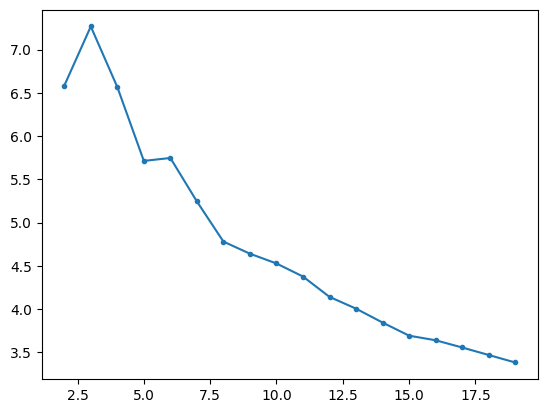

/Users/linch-pc/Documents/HSE/3rd_Course/Intellectual-data-processing/practice/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


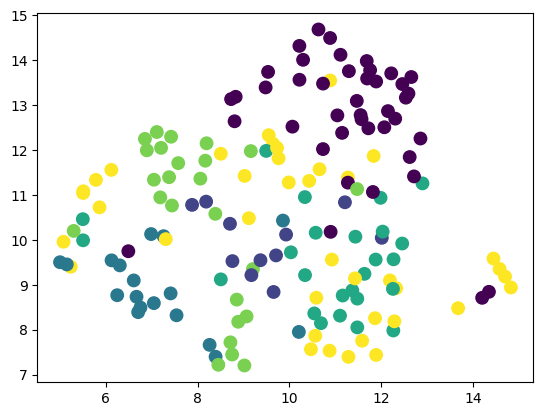

In [174]:
from umap.umap_ import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

umap_n = UMAP(n_neighbors=10, min_dist=0.5, random_state=0)
umap_v = umap_n.fit_transform(train_tf_X)
crit = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(train_tf_X)
    labels = kmeans.predict(train_tf_X)
    crit.append(davies_bouldin_score(train_tf_X.toarray(), labels))

plt.plot(range(2,20), crit, marker='.')

plt.show()

kmeans = KMeans(n_clusters=6, random_state=1).fit(train_tf_X)
labels = kmeans.predict(train_tf_X)

plt.scatter(umap_v[:, 0], umap_v[:, 1], s=80, c=kmeans.labels_)
